In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source column to each dataframe
df_iowait["source"] = "NETLOSS"
df_cpu_irq["source"] = "NETLOSS"
df_system_msec["source"] = "NETLOSS"
df_user_msec["source"] = "NETLOSS"
df_cpu_util["source"] = "NETLOSS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert time columns to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Select CPU columns
cpu_cols = [col for col in df_baseline_iowait.columns if col.startswith('cpu')]



## cpu io wait

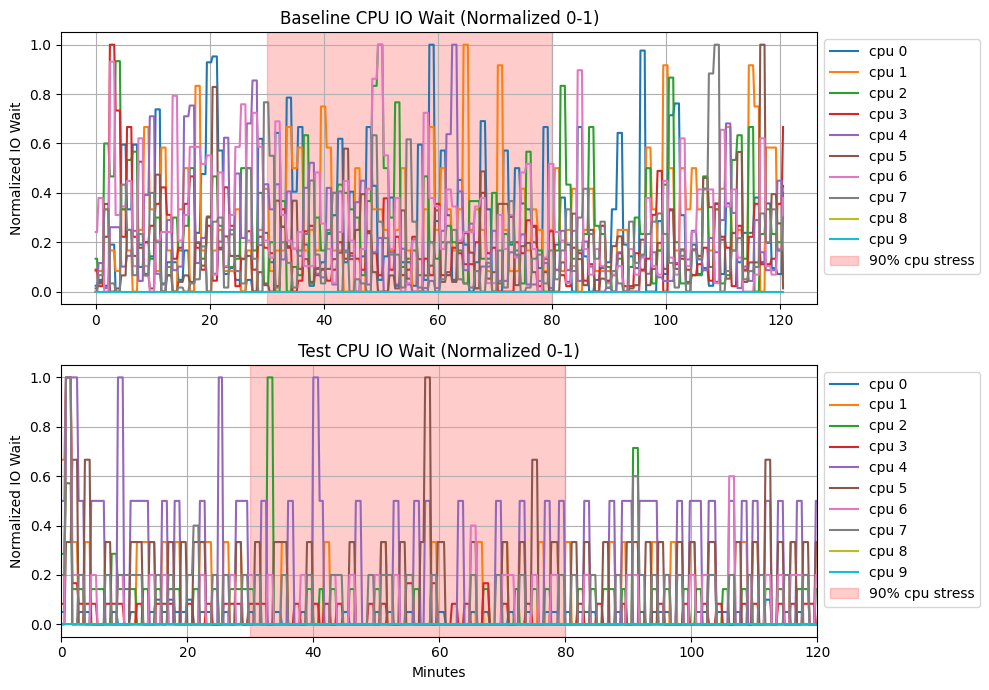

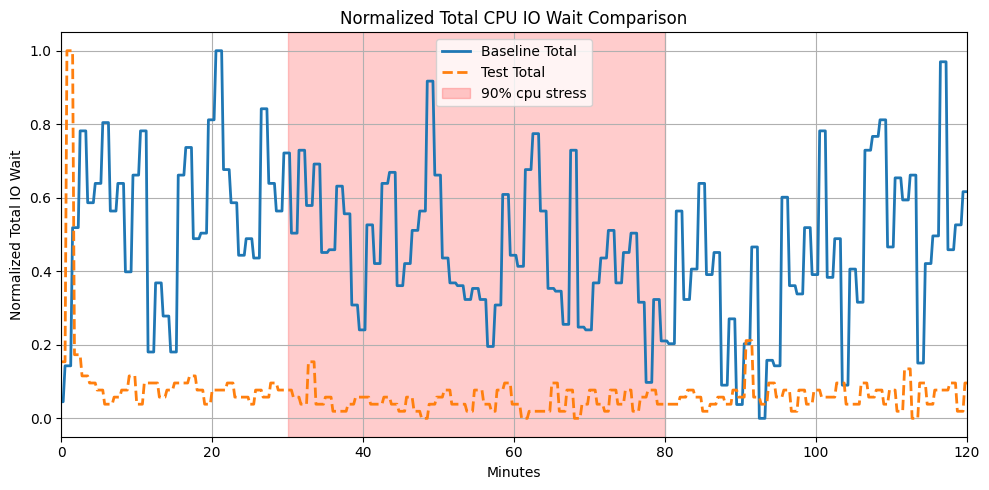

In [11]:
df_baseline_iowait['Time'] = pd.to_datetime(df_baseline_iowait['Time'])
df_iowait['Time'] = pd.to_datetime(df_iowait['Time'])


offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] = df_iowait["Time"] + offset

df_iowait["Minutes"] = (df_iowait["Time"] - df_iowait["Time"].min()).dt.total_seconds() / 60
df_baseline_iowait["Minutes"] = (df_baseline_iowait["Time"] - df_baseline_iowait["Time"].min()).dt.total_seconds() / 60

cpu_cols = [col for col in df_baseline_iowait.columns if col.startswith('cpu')]


delay = 30  # 30 minutes from start (1800 seconds)
duration = 50  # 50 minutes (3000 seconds)

def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

df_baseline_norm = normalize_df(df_baseline_iowait, cpu_cols)
df_iowait_norm = normalize_df(df_iowait, cpu_cols)

df_baseline_iowait['Total_iowait'] = df_baseline_iowait.iloc[:, 1:11].sum(axis=1)
df_iowait['Total_iowait'] = df_iowait.iloc[:, 1:11].sum(axis=1)

df_baseline_norm['Total_iowait'] = (df_baseline_iowait['Total_iowait'] - df_baseline_iowait['Total_iowait'].min()) / (df_baseline_iowait['Total_iowait'].max() - df_baseline_iowait['Total_iowait'].min())
df_iowait_norm['Total_iowait'] = (df_iowait['Total_iowait'] - df_iowait['Total_iowait'].min()) / (df_iowait['Total_iowait'].max() - df_iowait['Total_iowait'].min())

plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for col in cpu_cols:
    plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline CPU IO Wait (Normalized 0-1)")
plt.ylabel("Normalized IO Wait")
plt.grid(True)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.subplot(2, 1, 2)
for col in cpu_cols:
    plt.plot(df_iowait_norm["Minutes"], df_iowait_norm[col], label=col)
plt.title("Test CPU IO Wait (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized IO Wait")
plt.grid(True)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlim(0, 120)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(df_baseline_norm["Minutes"], df_baseline_norm['Total_iowait'], label="Baseline Total", linewidth=2)
plt.plot(df_iowait_norm["Minutes"], df_iowait_norm['Total_iowait'], label="Test Total", linewidth=2, linestyle='--')
plt.title("Normalized Total CPU IO Wait Comparison")
plt.xlabel("Minutes")
plt.ylabel("Normalized Total IO Wait")
plt.grid(True)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.legend()
plt.xlim(0, 120)
plt.tight_layout()
plt.show()


## cpu irq

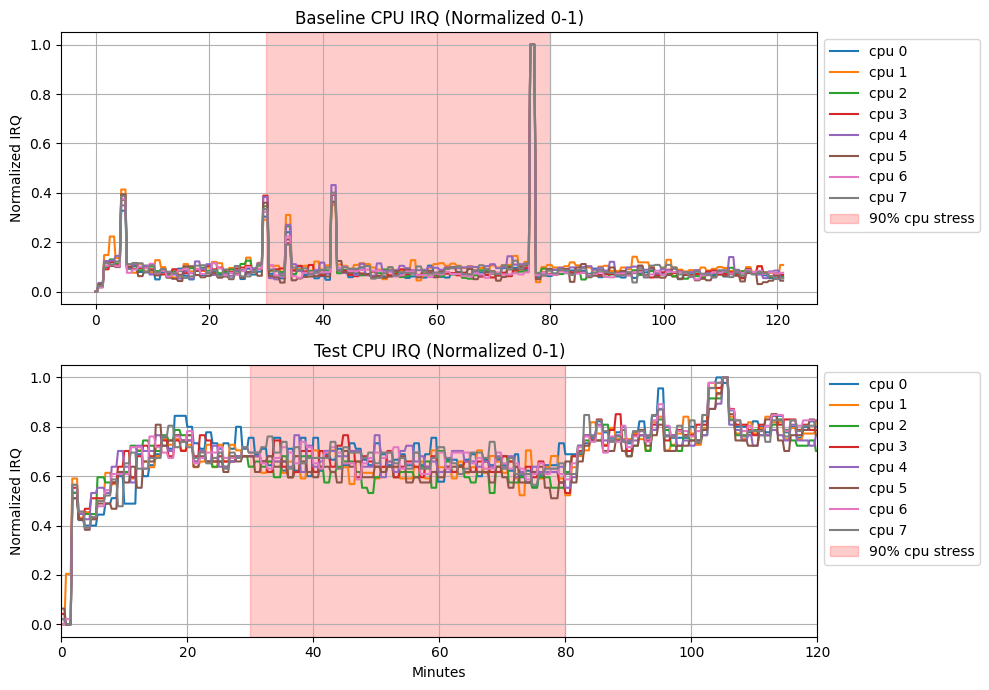

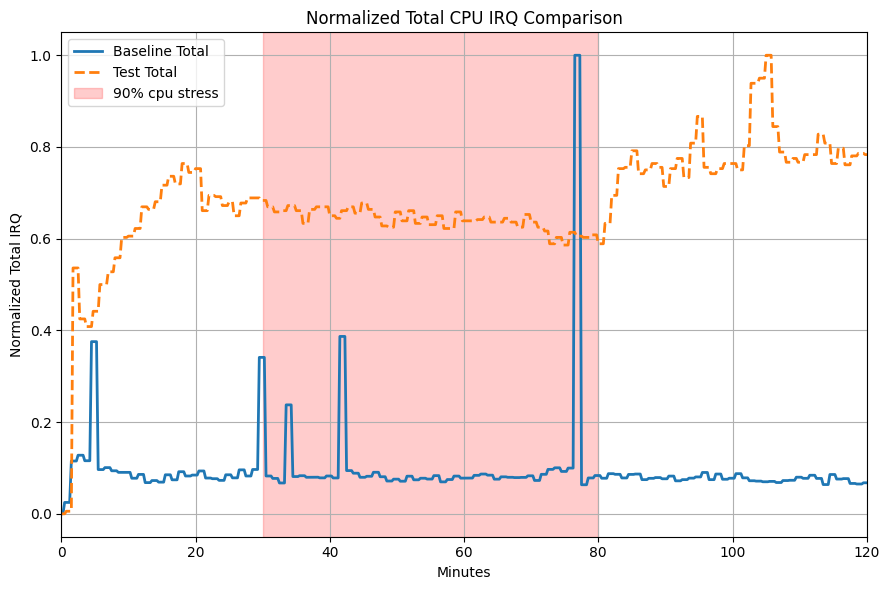

In [12]:
df_baseline_irq['Time'] = pd.to_datetime(df_baseline_irq['Time'])
df_cpu_irq['Time'] = pd.to_datetime(df_cpu_irq['Time'])

# Calculate time offset to align datasets
offset = df_baseline_irq["Time"].min() - df_cpu_irq["Time"].min()
df_cpu_irq["Time"] = df_cpu_irq["Time"] + offset

# Calculate minutes since start for each dataset
df_cpu_irq["Minutes"] = (df_cpu_irq["Time"] - df_cpu_irq["Time"].min()).dt.total_seconds() / 60
df_baseline_irq["Minutes"] = (df_baseline_irq["Time"] - df_baseline_irq["Time"].min()).dt.total_seconds() / 60

# Get list of CPU columns
cpu_cols = [col for col in df_baseline_irq.columns if col.startswith('cpu')]

# Define chaos injection period
delay = 30  # 30 minutes from start (1800 seconds)
duration = 50  # 50 minutes (3000 seconds)

# Create normalization function
def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

# Normalize the data
df_baseline_norm = normalize_df(df_baseline_irq, cpu_cols)
df_cpu_norm = normalize_df(df_cpu_irq, cpu_cols)

# Calculate total IRQ and normalize 
df_baseline_irq['Total_irq'] = df_baseline_irq.iloc[:, 1:11].sum(axis=1)
df_cpu_irq['Total_irq'] = df_cpu_irq.iloc[:, 1:11].sum(axis=1)

df_baseline_norm['Total_irq'] = (df_baseline_irq['Total_irq'] - df_baseline_irq['Total_irq'].min()) / (df_baseline_irq['Total_irq'].max() - df_baseline_irq['Total_irq'].min())
df_cpu_norm['Total_irq'] = (df_cpu_irq['Total_irq'] - df_cpu_irq['Total_irq'].min()) / (df_cpu_irq['Total_irq'].max() - df_cpu_irq['Total_irq'].min())

plt.figure(figsize=(10, 7))
# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline CPU IRQ (Normalized 0-1)")
plt.ylabel("Normalized IRQ")
plt.grid(True)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_cpu_norm["Minutes"], df_cpu_norm[col], label=col)
plt.title("Test CPU IRQ (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized IRQ")
plt.grid(True)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlim(0, 120)
plt.tight_layout()
plt.show()

# Create a separate figure for total IRQ comparison
plt.figure(figsize=(9, 6))
plt.plot(df_baseline_norm["Minutes"], df_baseline_norm['Total_irq'], label="Baseline Total", linewidth=2)
plt.plot(df_cpu_norm["Minutes"], df_cpu_norm['Total_irq'], label="Test Total", linewidth=2, linestyle='--')
plt.title("Normalized Total CPU IRQ Comparison")
plt.xlabel("Minutes")
plt.ylabel("Normalized Total IRQ")
plt.grid(True)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.legend()
plt.xlim(0, 120)
plt.tight_layout()
plt.show()

## cpu system msec

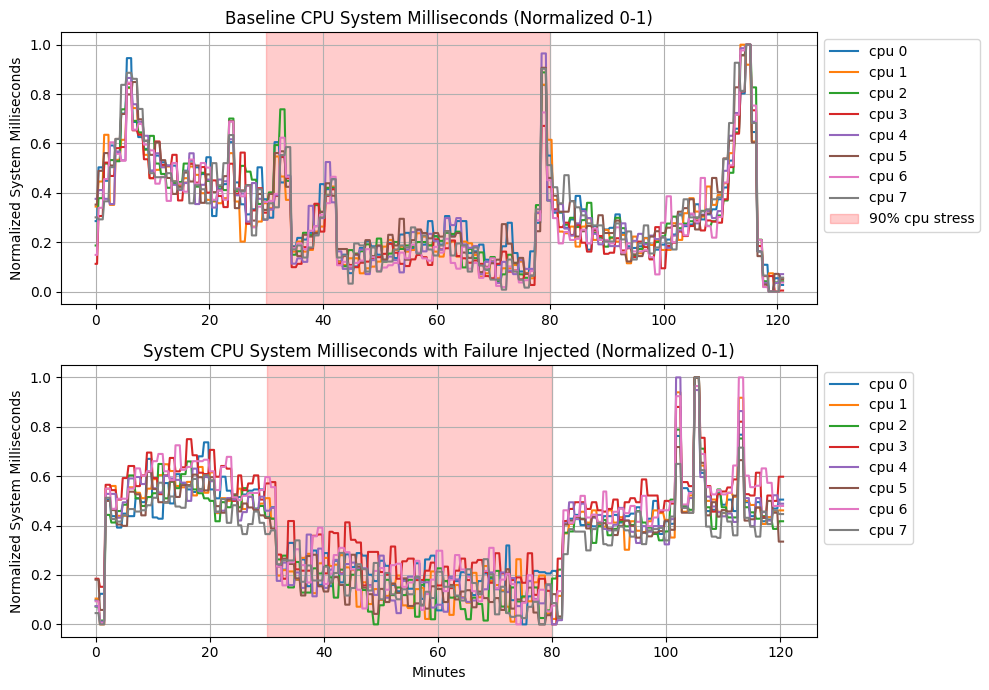

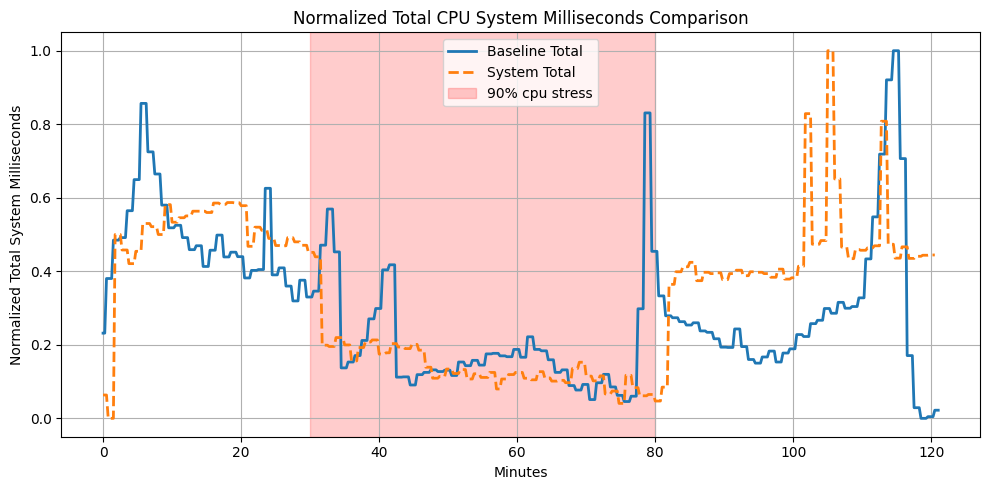

In [13]:
# Calculate minutes since start for each dataset
df_system_msec["Minutes"] = (df_system_msec["Time"] - df_system_msec["Time"].min()).dt.total_seconds() / 60
df_baseline_system_msec["Minutes"] = (df_baseline_system_msec["Time"] - df_baseline_system_msec["Time"].min()).dt.total_seconds() / 60

# Get list of CPU columns
cpu_cols = [col for col in df_baseline_system_msec.columns if col.startswith('cpu')]

# Create normalization function
def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

# Normalize the data
df_baseline_norm = normalize_df(df_baseline_system_msec, cpu_cols)
df_system_norm = normalize_df(df_system_msec, cpu_cols)

# Calculate total system msec and normalize 
df_baseline_system_msec['Total_sys'] = df_baseline_system_msec.iloc[:, 1:11].sum(axis=1)
df_system_msec['Total_sys'] = df_system_msec.iloc[:, 1:11].sum(axis=1)

df_baseline_norm['Total_sys'] = (df_baseline_system_msec['Total_sys'] - df_baseline_system_msec['Total_sys'].min()) / (df_baseline_system_msec['Total_sys'].max() - df_baseline_system_msec['Total_sys'].min())
df_system_norm['Total_sys'] = (df_system_msec['Total_sys'] - df_system_msec['Total_sys'].min()) / (df_system_msec['Total_sys'].max() - df_system_msec['Total_sys'].min())

# Create figure for normalized line plots - one for each dataset
plt.figure(figsize=(10, 7))

# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline CPU System Milliseconds (Normalized 0-1)")
plt.ylabel("Normalized System Milliseconds")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_system_norm["Minutes"], df_system_norm[col], label=col)
plt.title("System CPU System Milliseconds with Failure Injected (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized System Milliseconds")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(df_baseline_norm["Minutes"], df_baseline_norm['Total_sys'], label="Baseline Total", linewidth=2)
plt.plot(df_system_norm["Minutes"], df_system_norm['Total_sys'], label="System Total", linewidth=2, linestyle='--')
plt.title("Normalized Total CPU System Milliseconds Comparison")
plt.xlabel("Minutes")
plt.ylabel("Normalized Total System Milliseconds")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## cpu user msec

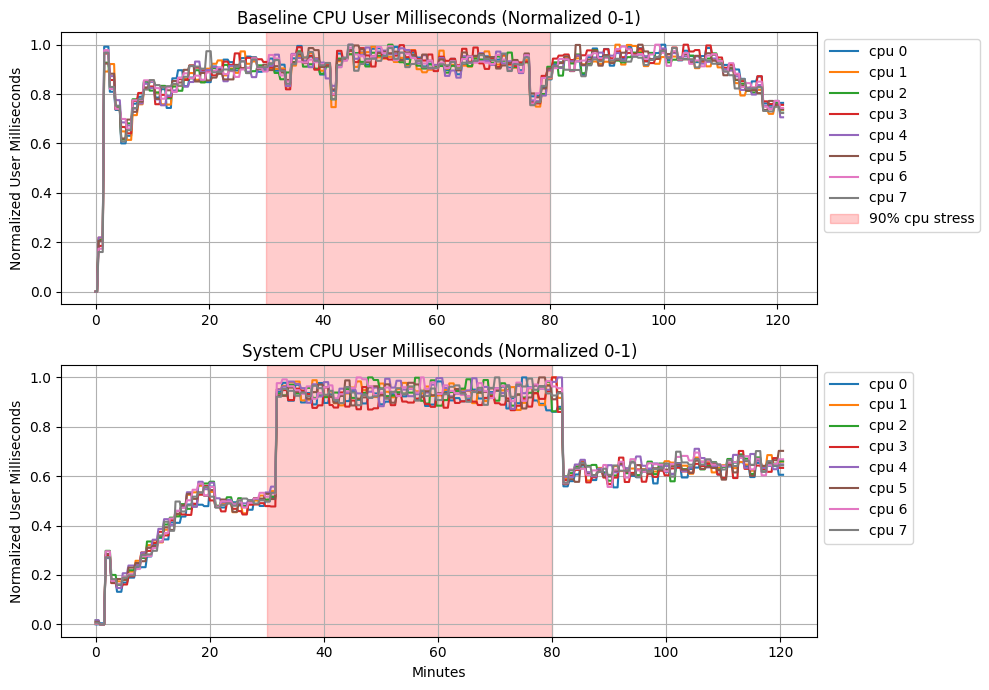

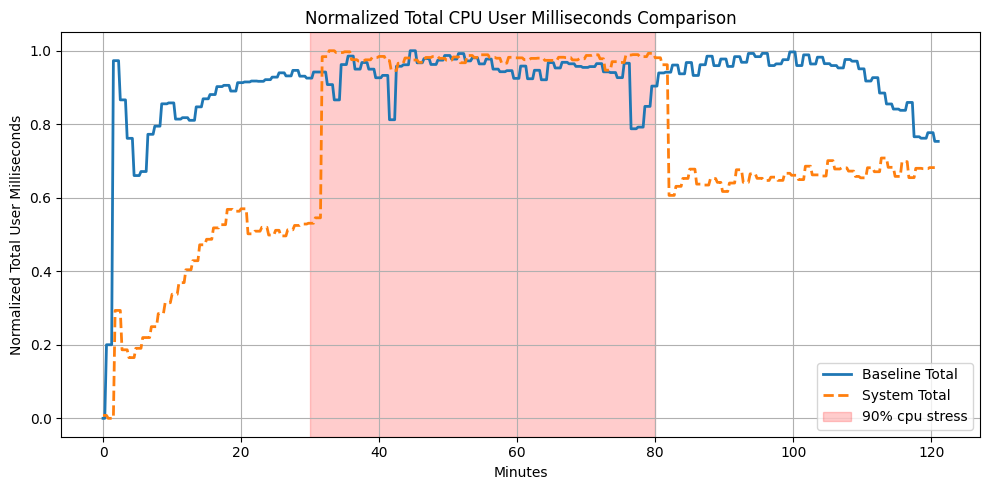

In [14]:
# Convert Time column to datetime
df_user_msec['Time'] = pd.to_datetime(df_user_msec['Time'])
df_baseline_user_msec['Time'] = pd.to_datetime(df_baseline_user_msec['Time'])

# Calculate minutes since start for each dataset
df_user_msec["Minutes"] = (df_user_msec["Time"] - df_user_msec["Time"].min()).dt.total_seconds() / 60
df_baseline_user_msec["Minutes"] = (df_baseline_user_msec["Time"] - df_baseline_user_msec["Time"].min()).dt.total_seconds() / 60

# Get list of CPU columns
cpu_cols = [col for col in df_baseline_user_msec.columns if col.startswith('cpu')]

# Define chaos injection period
delay = 30  # 30 minutes from start
duration = 50  # 50 minutes

# Create normalization function
def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

# Normalize the data
df_baseline_norm = normalize_df(df_baseline_user_msec, cpu_cols)
df_user_norm = normalize_df(df_user_msec, cpu_cols)

# Calculate total user msec and normalize 
df_baseline_user_msec['Total_user'] = df_baseline_user_msec.iloc[:, 1:11].sum(axis=1)
df_user_msec['Total_user'] = df_user_msec.iloc[:, 1:11].sum(axis=1)

df_baseline_norm['Total_user'] = (df_baseline_user_msec['Total_user'] - df_baseline_user_msec['Total_user'].min()) / (df_baseline_user_msec['Total_user'].max() - df_baseline_user_msec['Total_user'].min())
df_user_norm['Total_user'] = (df_user_msec['Total_user'] - df_user_msec['Total_user'].min()) / (df_user_msec['Total_user'].max() - df_user_msec['Total_user'].min())

# Create figure for normalized line plots - one for each dataset
plt.figure(figsize=(10, 7))

# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline CPU User Milliseconds (Normalized 0-1)")
plt.ylabel("Normalized User Milliseconds")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_user_norm["Minutes"], df_user_norm[col], label=col)
plt.title("System CPU User Milliseconds (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized User Milliseconds")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")

plt.tight_layout()
plt.show()

# Create a separate figure for total user milliseconds comparison
plt.figure(figsize=(10, 5))
plt.plot(df_baseline_norm["Minutes"], df_baseline_norm['Total_user'], label="Baseline Total", linewidth=2)
plt.plot(df_user_norm["Minutes"], df_user_norm['Total_user'], label="System Total", linewidth=2, linestyle='--')
plt.title("Normalized Total CPU User Milliseconds Comparison")
plt.xlabel("Minutes")
plt.ylabel("Normalized Total User Milliseconds")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## cpu util per

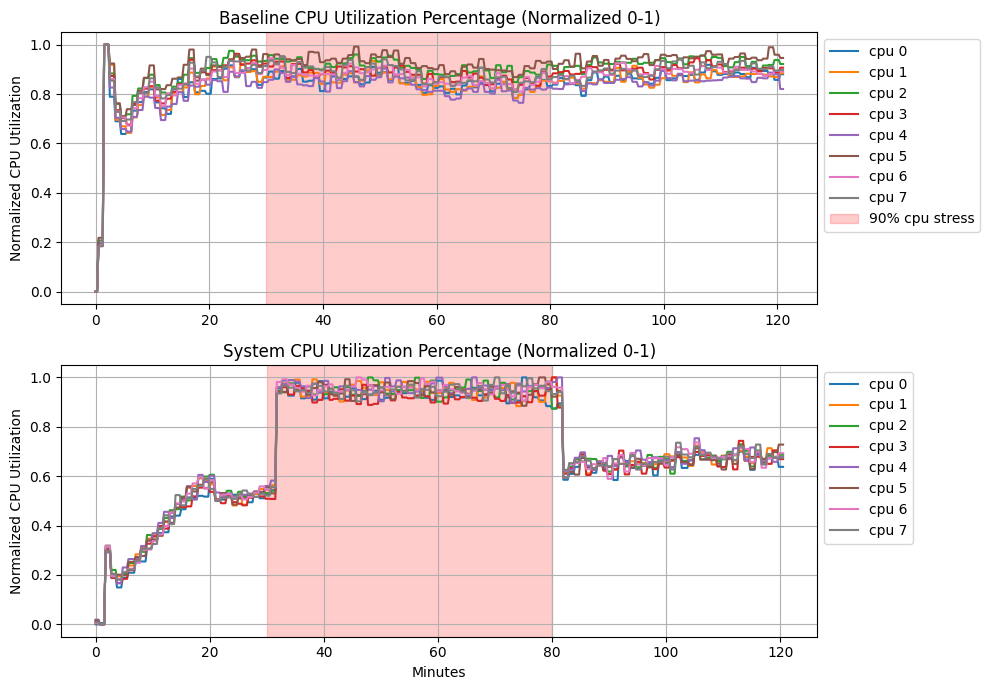

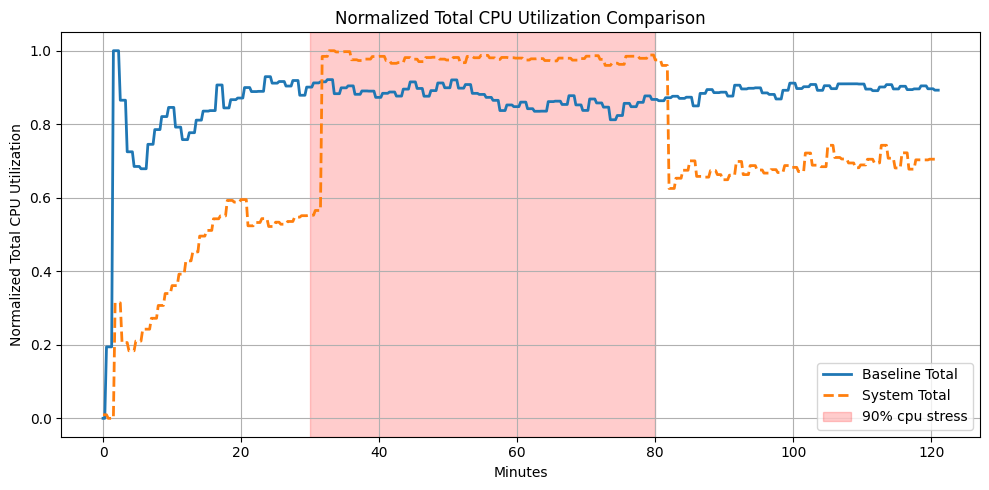

In [15]:
df_cpu_util['Time'] = pd.to_datetime(df_cpu_util['Time'])
df_baseline_util_per['Time'] = pd.to_datetime(df_baseline_util_per['Time'])

# Calculate minutes since start for each dataset
df_cpu_util["Minutes"] = (df_cpu_util["Time"] - df_cpu_util["Time"].min()).dt.total_seconds() / 60
df_baseline_util_per["Minutes"] = (df_baseline_util_per["Time"] - df_baseline_util_per["Time"].min()).dt.total_seconds() / 60

# Get list of CPU columns
cpu_cols = [col for col in df_baseline_util_per.columns if col.startswith('cpu')]

# Define chaos injection period
delay = 30  # 30 minutes from start
duration = 50  # 50 minutes

# Create normalization function
def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

# Normalize the data
df_baseline_norm = normalize_df(df_baseline_util_per, cpu_cols)
df_cpu_norm = normalize_df(df_cpu_util, cpu_cols)

# Calculate total CPU utilization and normalize 
df_baseline_util_per['Total_util'] = df_baseline_util_per.iloc[:, 1:11].sum(axis=1)
df_cpu_util['Total_util'] = df_cpu_util.iloc[:, 1:11].sum(axis=1)

df_baseline_norm['Total_util'] = (df_baseline_util_per['Total_util'] - df_baseline_util_per['Total_util'].min()) / (df_baseline_util_per['Total_util'].max() - df_baseline_util_per['Total_util'].min())
df_cpu_norm['Total_util'] = (df_cpu_util['Total_util'] - df_cpu_util['Total_util'].min()) / (df_cpu_util['Total_util'].max() - df_cpu_util['Total_util'].min())

# Create figure for normalized line plots - one for each dataset
plt.figure(figsize=(10, 7))

# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline CPU Utilization Percentage (Normalized 0-1)")
plt.ylabel("Normalized CPU Utilization")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cpu_cols:
    if col not in ['cpu 8', 'cpu 9']:  # Skip unused CPUs
        plt.plot(df_cpu_norm["Minutes"], df_cpu_norm[col], label=col)
plt.title("System CPU Utilization Percentage (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized CPU Utilization")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")

plt.tight_layout()
plt.show()

# Create a separate figure for total CPU utilization comparison
plt.figure(figsize=(10, 5))
plt.plot(df_baseline_norm["Minutes"], df_baseline_norm['Total_util'], label="Baseline Total", linewidth=2)
plt.plot(df_cpu_norm["Minutes"], df_cpu_norm['Total_util'], label="System Total", linewidth=2, linestyle='--')
plt.title("Normalized Total CPU Utilization Comparison")
plt.xlabel("Minutes")
plt.ylabel("Normalized Total CPU Utilization")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="90% cpu stress")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()